On veut savoir si notre algorithme fournira les mêmes segmentations dans le futur, alors on va simuler le futur.


Les données entières sont disponibles pour 18 mois, du 01/01/2017 à 01/08/2018 (données avant janvier 2017 et après aout 2018 ont trop éparses)

Pour étudier la stabilité des clusters au cours du temps, nous allons calculer l'écart entre un predict du modèle initial et le fit d'un nouveau modèle grâce à la fonction Ajusted_Rand_Score de la façon suivante: adjusted_rand_score(labels_true, labels_pred)

La fonction Ajusted_Rand_Score calcule une mesure de similarité entre deux clusters en considérant toutes les paires d'échantillons et en comptant les paires qui sont assignées dans le même cluster ou dans des clusters différents dans les clusters prédits et réels.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from dateutil.relativedelta import *
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

# chargement des données

In [2]:
df = pd.read_feather('cleaned_data_jointed.feather')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106776 entries, 0 to 106775
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   index                          106776 non-null  int64         
 1   order_id                       106776 non-null  object        
 2   customer_id                    106776 non-null  object        
 3   order_status                   106776 non-null  object        
 4   order_purchase_timestamp       106776 non-null  datetime64[ns]
 5   order_approved_at              106776 non-null  datetime64[ns]
 6   order_delivered_carrier_date   106776 non-null  datetime64[ns]
 7   order_delivered_customer_date  106776 non-null  datetime64[ns]
 8   order_estimated_delivery_date  106776 non-null  datetime64[ns]
 9   customer_unique_id             106776 non-null  object        
 10  customer_zip_code_prefix       106776 non-null  float64       
 11  

In [4]:
import datetime
max_date = max(df.order_purchase_timestamp) + datetime.timedelta(days=1)
print(max_date)
df["delivery_delay"] = (df["order_delivered_customer_date"] - df["order_purchase_timestamp"]).dt.days
df["delivery_delay_estimation"] = (df["order_estimated_delivery_date"]- df["order_purchase_timestamp"]).dt.days
review_score = df.groupby('customer_unique_id')['review_score'].mean()
df['mean_review_score'] = df['customer_unique_id'].map(review_score)

2018-08-30 15:00:37


In [5]:
START_DATE = pd.to_datetime('01/01/2017', format='%d/%m/%Y')
END_DATE =  pd.to_datetime('01/01/2018', format='%d/%m/%Y')
NEW_START_DATE = END_DATE
number_months = 8
end_date = [NEW_START_DATE]
for i in range (1,number_months+1):
    end_date.append(NEW_START_DATE+relativedelta(months=+i))

# Calculer la base de  référence B0

In [6]:
def calculer_B0 (df , start_date=START_DATE, end_date=END_DATE, date_col='order_purchase_timestamp'):

    return df[(df[date_col] >= start_date) & (df[date_col] < end_date)]

In [7]:
B0 = calculer_B0(df)
B0

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,delivery_delay,delivery_delay_estimation,mean_review_score
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,...,19.0,8.0,13.0,housewares,9350.0,maua,SP,8,15,4.333333
1,2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,...,19.0,8.0,13.0,housewares,9350.0,maua,SP,8,15,4.333333
2,3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,3a51803cc0d012c3b5dc8b7528cb05f7,...,19.0,8.0,13.0,housewares,9350.0,maua,SP,2,12,4.000000
3,4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,ef0996a1a279c26e7ecbd737be23d235,...,19.0,8.0,13.0,housewares,9350.0,maua,SP,5,12,5.000000
4,5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13,e781fdcc107d13d865fc7698711cc572,...,19.0,8.0,13.0,housewares,9350.0,maua,SP,14,20,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106761,114512,a4e589b74835bc3afcbd2f9e8c5f7fd5,8b395f74a33054bc1e054c5b9348df51,delivered,2017-08-18 13:19:58,2017-08-22 04:16:21,2017-08-25 18:16:49,2017-09-01 17:32:10,2017-09-11,8b843efe35f8a54b66f7abf3e460e84d,...,23.0,14.0,23.0,housewares,1417.0,sao paulo,SP,14,23,5.000000
106763,114514,e039f5e97da2cafaa001b4be0efa36ea,4200397cebae27f5becd25dc019f0fe6,delivered,2017-11-26 10:19:20,2017-11-26 10:35:56,2017-11-27 18:53:15,2018-01-04 16:58:51,2017-12-18,8d26dcd57028c52b03c6b57fac350467,...,22.0,8.0,15.0,garden_tools,37540.0,santa rita do sapucai,MG,39,21,1.000000
106766,114517,39e89b39b5cc8b5e3a38f23e915d1823,2b91bc260dcffbdacd12c4b09e5c7463,delivered,2017-07-24 11:29:43,2017-07-24 11:43:21,2017-07-24 22:34:38,2017-08-10 19:42:10,2017-08-23,bd0a735ae91504c00c71638c720e3cca,...,16.0,7.0,11.0,auto,2116.0,sao paulo,SP,17,29,5.000000
106767,114519,fbff77db5421bb7e1da292db45d07e75,7795e3faa6e16fc40aafee568b25a85d,delivered,2017-03-15 11:41:46,2017-03-15 11:41:46,2017-03-16 04:19:03,2017-03-20 10:34:54,2017-04-03,6ee4fdb7edab032aaa8392bab5446546,...,28.0,2.0,18.0,books_technical,6080.0,osasco,SP,4,18,5.000000


# Calculer les base de futur B1, B2, ...

In [8]:
def calculer_df_par_mois(df, n , new_start_date=NEW_START_DATE, date_col='order_purchase_timestamp') : 
    
    # n est le nombre de mois à ajouter 
    end_date = new_start_date+relativedelta(months=+n)
   
    return df[(df[date_col] >= new_start_date) & (df[date_col] < end_date)]

In [9]:
B= {}
for i in range(1,number_months+1):
        B[f"B{i}"] = calculer_df_par_mois(df,i)

# Calculer les indicateurs

On calcule les indicateurs pour chaque base de donnée B0 , B1 ....

In [10]:

def selectionner_variables(df):
    
    df_tolearn = df.groupby("customer_unique_id").agg({
                                                        "delivery_delay" :"mean",
                                                        "delivery_delay_estimation" : 'mean',
                                                        "payment_installments" : "mean",
                                                        "review_score":"mean",
                                                        "payment_value" : "mean",
                                                        "order_purchase_timestamp" : lambda x: (max_date - x.max()).days,
        
})
    df_tolearn.columns = ["mean_delivery_delay","mean_delivery_delay_estimation","mean_payment_installments", 
                         "mean_review_score","MonetaryValue","Frequency"]
    df_tolearn.reset_index()
   # df_tolearn =df_tolearn.drop(['customer_unique_id'], axis=1)
    return df_tolearn

In [11]:
B0_data = selectionner_variables(B0)

In [12]:
B0_data

,mean_delivery_delay,mean_delivery_delay_estimation,mean_payment_installments,mean_review_score,MonetaryValue,Frequency
customer_unique_id,,,,,,
0000f46a3911fa3c0805444483337064,25.0,27.0,8.0,3.0,86.22,537
0000f6ccb0745a6a4b88665a16c9f078,20.0,31.0,4.0,4.0,43.62,321
0004aac84e0df4da2b147fca70cf8255,13.0,20.0,6.0,5.0,196.89,288
0005e1862207bf6ccc02e4228effd9a0,4.0,32.0,3.0,4.0,150.12,543
0006fdc98a402fceb4eb0ee528f6a8d4,16.0,27.0,2.0,3.0,29.00,408
...,...,...,...,...,...,...
fffa431dd3fcdefea4b1777d114144f2,10.0,17.0,1.0,5.0,81.20,303
fffb09418989a0dbff854a28163e47c6,8.0,31.0,1.0,5.0,73.16,255
fffea47cd6d3cc0a88bd621562a9d061,30.0,32.0,1.0,4.0,84.58,262


In [13]:
B_data = {}
for i in range(1,number_months+1):
        B_data[f"B{i}_data"] = selectionner_variables(B[f"B{i}"])

In [14]:
B_data["B8_data"]

,mean_delivery_delay,mean_delivery_delay_estimation,mean_payment_installments,mean_review_score,MonetaryValue,Frequency
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,6.0,10.0,8.0,5.0,141.90,112
0000b849f77a49e4a4ce2b2a4ca5be3f,3.0,7.0,1.0,4.0,27.19,115
0004bd2a26a76fe21f786e4fbd80607f,1.0,13.0,8.0,4.0,166.98,146
00050ab1314c0e55a6ca13cf7181fecf,6.0,18.0,1.0,4.0,35.38,132
00053a61a98854899e70ed204dd4bafe,16.0,25.0,3.0,1.0,419.18,183
...,...,...,...,...,...,...
fff22793223fe80c97a8fd02ac5c6295,2.0,19.0,1.0,5.0,89.19,65
fff2ae16b99c6f3c785f0e052f2a9cfb,21.0,41.0,8.0,5.0,200.90,132
fff3e1d7bc75f11dc7670619b2e61840,10.0,18.0,1.0,5.0,82.51,41


# Standardisation et modélisation

On apprend un standardScaler sur base donnée global 

In [15]:
std= StandardScaler()
df_B0_B8 = pd.concat([B0_data, B_data[f"B{number_months}_data"]])
df_B0_B8_sacler = std.fit(df_B0_B8)

In [16]:
df_B0_B8.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88566 entries, 0000f46a3911fa3c0805444483337064 to ffff5962728ec6157033ef9805bacc48
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   mean_delivery_delay             88566 non-null  float64
 1   mean_delivery_delay_estimation  88566 non-null  float64
 2   mean_payment_installments       88566 non-null  float64
 3   mean_review_score               88566 non-null  float64
 4   MonetaryValue                   88566 non-null  float64
 5   Frequency                       88566 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 4.7+ MB


In [17]:
def standard_and_model(df, n ,std):
    
    d = {}
    d[f"data_scaled{n}"]= std.transform(df)
    d[f"B{n}_scaled"]  = pd.DataFrame(d[f"data_scaled{n}"], columns=df.columns)
    d[f"B{n}_model"] = KMeans(n_clusters = 7).fit(d[f"B{n}_scaled"])
    d[f"fit_cluster{n}"] = d[f"B{n}_model"].labels_

    return d[f"B{n}_scaled"],d[f"B{n}_model"],d[f"fit_cluster{n}"]

In [18]:
C0_clusters = standard_and_model(B0_data,0,df_B0_B8_sacler)

In [19]:
C_clusters = {}
for i in range(1,number_months+1):
        C_clusters[f"C{i}_fit"]=standard_and_model(B_data[f"B{i}_data"],i,df_B0_B8_sacler)
        
        
    # prédiction des nouvelles bdds sur C0    
for i in range(1,number_months+1):
        C_clusters[f"C{i}_predict_on_C0"] = C0_clusters[1].predict(C_clusters[f"C{i}_fit"][0])

    # les prédiction des nouvelles bdd sur leur Bn
for i in range(1,number_months+1):    

        C_clusters[f"C{i}_fit_on_B{i}"] = C_clusters[f"C{i}_fit"][1].predict(C_clusters[f"C{i}_fit"][0])

In [20]:
     
    #comparaison ARI score
df_ari = pd.DataFrame(columns=["month_added", "ARI_score"])
df_ari = df_ari.append({
                    'month_added': 0,
                    'ARI_score': adjusted_rand_score(C0_clusters[1].predict(C0_clusters[0]),C0_clusters[2] )
                }, ignore_index=True)


for i in range (1,number_months+1):

           df_ari = df_ari.append(
            {
                "month_added": i,
                "ARI_score": adjusted_rand_score(C_clusters[f"C{i}_predict_on_C0"] , C_clusters[f"C{i}_fit_on_B{i}"]          
                ),
            },
            ignore_index=True,
        )

In [21]:
df_ari

,month_added,ARI_score
0,0.0,1.000000
1,1.0,0.798857
2,2.0,0.488931
3,3.0,0.476590
4,4.0,0.487354
5,5.0,0.489982
6,6.0,0.490186
7,7.0,0.500284
8,8.0,0.514130


# Visualisation ARI


In [22]:
def plot_ari(df_ari,end_date):
    plt.figure(figsize=(10, 7))
    sns.lineplot(data=df_ari, x= end_date, y='ARI_score', marker='o', markerfacecolor='r')
    plt.title("Rand Score (ARI)")
    plt.axhline(y=0.8, color='r', linestyle='--')
    #plt.axhline(y=0.8, color='r', linestyle='--')
    sns.despine()

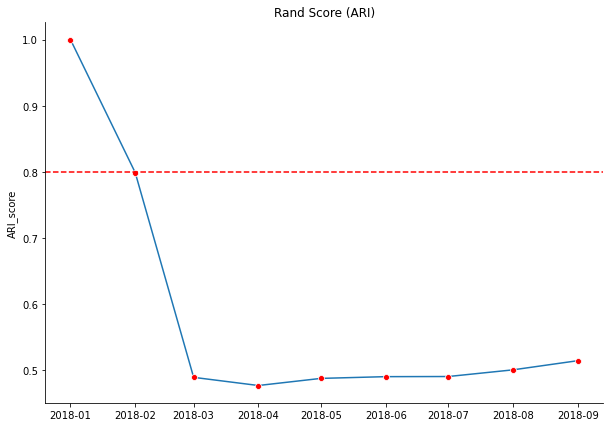

In [23]:
plot_ari(df_ari,end_date)